In [1]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torch import functional as F
from torch import nn

import torch
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Генератор батчей


In [2]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    for i in range(0, len(X), batch_size):
        idxs = perm[i: i+batch_size]
        yield X[idxs], y[idxs]

Проверим, что генератор батчей является генератором и работает.

In [3]:
from inspect import isgeneratorfunction
assert isgeneratorfunction(batch_generator), "batch_generator должен быть генератором! В условии есть ссылка на доки"

X = np.array([
              [1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]
])
y = np.array([
              1, 2, 3
])

# Проверим shape первого батча
iterator = batch_generator(X, y, 2)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (2, 3), y_batch.shape == (2,)
assert np.allclose(X_batch, X[:2]), np.allclose(y_batch, y[:2])

# Проверим shape последнего батча (их всего два)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (1, 3), y_batch.shape == (1,)
assert np.allclose(X_batch, X[2:]), np.allclose(y_batch, y[2:])

# Проверим, что итерации закончились
iter_ended = False
try:
    next(iterator)
except StopIteration:
    iter_ended = True
assert iter_ended

# Еще раз проверим то, сколько батчей создает итератор
X = np.random.randint(0, 100, size=(1000, 100))
y = np.random.randint(-1, 1, size=(1000, 1))
num_iter = 0
for _ in batch_generator(X, y, 3):
    num_iter += 1
assert num_iter == (1000 // 3 + 1)

# 2. Обучение модели для классификации звёзд

Загрузим датасет `sky_data.csv`

In [19]:
data = pd.read_csv('https://drive.google.com/uc?id=1K-8CtATw6Sv7k2dXco1fL5MAhTbKtIH3')
data['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [20]:
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


## Загрузка и обработка данных

### Выявление признаков и target-переменной

In [21]:
feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field'] # выделяем признаки, на которых будем обучать нейросеть.
target_column = 'class' #выделяем target-признак

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}

Выберем из dataframe столбцы, являющиеся признаками и столбец, являющийся target. 

In [22]:
X = data[feature_columns] # Extract Features
y = data[target_column] # Extract target

In [23]:
y = np.array(y.map(target_mapping))#заменяем Galaxy -> 0, STAR ->1, QSO ->2

In [25]:
X.shape

(10000, 10)

### Нормализация данных

Нормализацию можно сделать двумя способами: 

1. `StandardScaler`

2. Вручную: $ \frac{x - \bar{x}}{\sqrt{\sigma^2}} \sim N(0,1)$

In [0]:
#1. First
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

assert type(X) == np.ndarray and type(y) == np.ndarray, 'Проверьте, что получившиеся массивы являются np.ndarray'
assert np.allclose(y[:5], [1,1,0,1,1])
assert X.shape == (10000, 10)
assert np.allclose(X.mean(axis=0), np.zeros(10)) and np.allclose(X.std(axis=0), np.ones(10)), 'Данные не отнормированы'


In [0]:
#2. Second (amount of df = N, NOT df = N-1, so ddof  = 0)
X = np.array((X - X.mean()) / X.std(ddof=0))
assert type(X) == np.ndarray and type(y) == np.ndarray, 'Проверьте, что получившиеся массивы являются np.ndarray'
assert np.allclose(y[:5], [1,1,0,1,1])
assert X.shape == (10000, 10)
assert np.allclose(X.mean(axis=0), np.zeros(10)) and np.allclose(X.std(axis=0), np.ones(10)), 'Данные не отнормированы'

Разбиваем данные на train/test, после превращаем данные в тензоры.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # Split train/test
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

Напишем модель нейронной сети по следующей архитектуре.

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) 
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

In [0]:
torch.manual_seed(42)   
np.random.seed(42)

model = nn.Sequential(
    torch.nn.Linear(len(feature_columns),50), #Dense Layer, 50 neurons
    torch.nn.ReLU(), #ReLU
    torch.nn.Dropout(p=0.5), #Try 0.8, 0.5 works better
    torch.nn.BatchNorm1d(50), #Norm 50 Neurons in Layer
    torch.nn.Linear(50,100), #Dense Layer, 100 neurons, 50 neurons on Previous Layer
    torch.nn.ReLU(), #Relu
    torch.nn.Dropout(p=0.5), #Dropout 0.5 
    torch.nn.BatchNorm1d(100), #Norm Our 100 neurons
    torch.nn.Linear(100,len(target_mapping)), # Output Dense, 100 Neurons on Last Dense, Output - Probability of 3 classes
    
)

loss_fn = nn.CrossEntropyLoss() # add loss function - cross entropy
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2) # use Adam optimizer, lr = 0.01

Напишем функцию тренировки модели.

In [0]:
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        epoch_train_losses = []
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            y_pred = model(X_batch) # prediction
            loss = loss_fn(y_pred, y_batch) #loss on prediction and batch
            optimizer.zero_grad()# зануляем градиент
            loss.backward()# backward
            optimizer.step()# ОБНОВЛЯЕМ веса
            epoch_train_losses.append(loss.item()) #add number in batch train loss     
        train_losses.append(np.mean(epoch_train_losses))
        # test loss
        model.train(False)
        
        with torch.no_grad():
            test_losses.append(loss_fn(model(X_test), y_test).item()) #add number in batch test loss   
            
    return train_losses, test_losses

In [0]:
def check_loss_decreased():
    print("На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]")
    s = input()
    if s.lower() == 'да':
        print("Хорошо!")
    else:
        raise RuntimeError("Можно уменьшить дропаут, уменьшить lr, поправить архитектуру, etc")

Выведем графики `train losses` и `test_losses`.

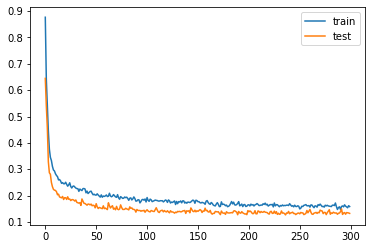

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!


In [15]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, 300)
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3

Видно на графике, что сходимость  `train losses` и `test_losses` видна, проверим, как работает наша модель с помощью `accuracy_score`.

In [16]:
from sklearn.metrics import accuracy_score

model.eval()
train_pred_labels = np.argmax(model.forward(X_train).detach().numpy(), axis = 1)
test_pred_labels = np.argmax(model.forward(X_test).detach().numpy(), axis = 1)

train_acc = accuracy_score(train_pred_labels,y_train)
test_acc = accuracy_score(test_pred_labels,y_test)

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))

Train accuracy: 0.9661333333333333
Test accuracy: 0.96


Это очень хорошее качество модели.

# 3. Исправление ошибок в архитектуре
Найдем ошибка в архитектуре по следующим правилам:
1. Если вы видите лишний нелинейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сделать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)
2. Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию
3. Если что-то не так с learning_rate, то поставьте 1e-2
4. Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).
5. Ошибки могут быть и в полносвязных слоях. 
6. Любые другие проблемы решаются более менее однозначно.

Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.

**Ответ на задачу - средний лосс на тестовом датасете**

Давайте покажем, какие ошибки были обнаружены в данной модели.

In [0]:
torch.manual_seed(42)   
np.random.seed(42)
# WRONG ARCH
model = nn.Sequential(
    nn.Dropout(p=0.5), #Dropout before Layer
    nn.Linear(6, 50), #amount of input features = 6, our features.shape = 10
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 200),#amount of neurons on Previous Layer is 50, but in this Layer is 100.
    nn.Softmax(), #hm, we will se, that model works better with Softmax, this is acceptable
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
    nn.Dropout(p=0.5) # last Dense no dropout need
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters[:-2], lr=1e-100) # lr = 1e-2, model.parameters()

Напишем две модели, которые учитывают ошибки построение модели.

1. Первая будет с `Dropout(p=0.5)` вместо `Softmax`

In [0]:
torch.manual_seed(42)   
np.random.seed(42)

model = nn.Sequential(
    torch.nn.Linear(10,50), #Dense Layer, 50 neurons
    torch.nn.ReLU(), #ReLU
    torch.nn.Dropout(p=0.5), #0.5 works better
    torch.nn.Linear(50,200), #Dense Layer, 200 neurons
    torch.nn.ReLU(), #Relu
    torch.nn.Dropout(p=0.5), #0.5 works better
    torch.nn.Linear(200,200), #Dense Layer, 200 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(200,len(target_mapping)), # Output Dense, 200 Neurons on Last Dense, Output - Probability of 3 classes
    
)

loss_fn = nn.CrossEntropyLoss() # add loss function  -cross entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) # use Adam optimizer

Начнем с первой, будем считать среднее значение `np.mean(test_looses)` ответом на задачу.

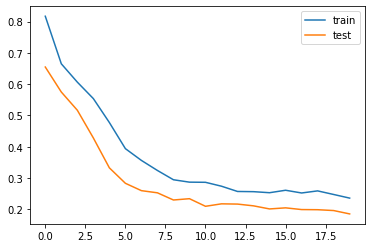

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!
ОТВЕТ К ЗАДАНИЮ, СРЕДНИЙ ЛОСС НА ДАТАСЕТЕ =  0.2903190


In [18]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, 20)
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3

print('ОТВЕТ К ЗАДАНИЮ, СРЕДНИЙ ЛОСС НА ДАТАСЕТЕ =  %.7f' % np.mean(test_losses))

На 20 эпохах графики конечно фигово сходятся, но если взглянуть на 300 эпох, то все будет хорошо.

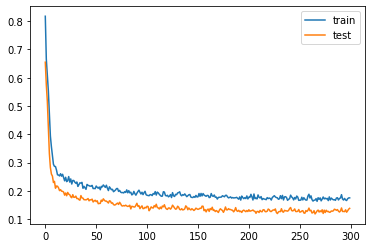

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!


0.15083494702974956

In [20]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, 300)
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3
np.mean(test_losses)

Проверим Accuracy.

In [21]:
model.eval()
train_pred_labels = np.argmax(model.forward(X_train).detach().numpy(), axis = 1)
test_pred_labels = np.argmax(model.forward(X_test).detach().numpy(), axis = 1)

train_acc = accuracy_score(train_pred_labels,y_train)
test_acc = accuracy_score(test_pred_labels,y_test)

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))

Train accuracy: 0.9614666666666667
Test accuracy: 0.9556


2. вторая - Softmax на втором слое оставляем.

In [0]:
torch.manual_seed(42)   
np.random.seed(42)

model = nn.Sequential(
    torch.nn.Linear(10,50), #Dense Layer, 50 neurons
    torch.nn.ReLU(), #ReLU
    torch.nn.Dropout(p=0.5), #0.5 works better
    torch.nn.Linear(50,200), #Dense Layer, 200 neurons
    torch.nn.ReLU(), #Relu
    torch.nn.Softmax(),
    torch.nn.Linear(200,200), #Dense Layer, 200 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(200,len(target_mapping)),  # Output Dense, 200 Neurons on Last Dense, Output - Probability of 3 classes
    
)

loss_fn = nn.CrossEntropyLoss() # add loss function  -cross entropy
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2) # use Adam optimizer

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


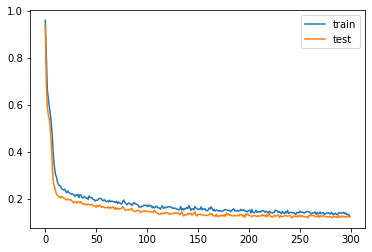

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!


0.1539632722735405

In [23]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, 300)
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3
np.mean(test_losses)

О! Видим, что сходится гораздо лучше, чем предудыщая модель. Посмотрим на Accuracy.

In [24]:
model.eval()
train_pred_labels = np.argmax(model.forward(X_train).detach().numpy(), axis = 1)
test_pred_labels = np.argmax(model.forward(X_test).detach().numpy(), axis = 1)

train_acc = accuracy_score(train_pred_labels,y_train)
test_acc = accuracy_score(test_pred_labels,y_test)

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))

Train accuracy: 0.9718666666666667
Test accuracy: 0.9652


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


И accuracy с Softmax тоже работает лучше. 

**Вывод**: так что для соревнований мы бы выбрали вторую модель, но по правилам чистки модели, которая должна произойти в этом задании, выберем первую модель и средний лосс равный примерно 0.29.

# Задание 4. Stack layers


Давайте посмотрим, когда добавление перестает улучшать метрики. Увеличивайте блоков из слоев в сети, пока минимальный лосс на тестовом датасете за все время обучения не перестанет уменьшаться (20 эпох). 

Стоит помнить, что нельзя переиспользовать слои с предыдущих обучений, потому что они уже будут с подобранными весами.

**Чтобы получить воспроизводимость и идентичный нашему ответ, надо объявлять все слои в порядке, в котором они применяются внутри модели. Это важно, если вы будете собирать свою модель из частей. Перед объявлением этих слоев по порядку напишите**
> torch.manual_seed(42)   
> np.random.seed(42)

**При чем каждый раз, когда вы заново создаете модель, перезадавайте random seeds**

**Опитимизатор - Adam(lr=1e-2)**

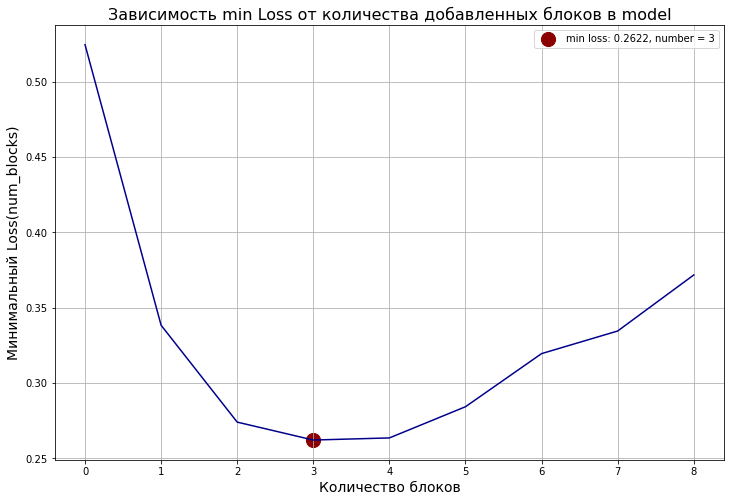

In [25]:
#from IPython.core.display import clear_output
#clear_output(wait=True)

def block(num_blocks):
    header = nn.Sequential(torch.nn.Linear(10, 100), nn.ReLU(), nn.Dropout(p=0.5))
    # добавляем количество блоков, равное `num_blocks`
    blocks = [nn.Sequential(nn.Linear(100, 100), nn.ReLU(), nn.BatchNorm1d(100)) for i in range(num_blocks)]
    # добавляем footer, выходной слой модели
    footer = nn.Sequential(nn.Linear(100, 3))
    # модель складываем по частям
    model = nn.Sequential(header, *blocks, footer)
    return model

test_losses_min = []
num_block_maxi = 8

for num_count in range(num_block_maxi+1):    
    torch.manual_seed(42)
    np.random.seed(42)

    model = block(num_count)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_losses, test_losses = train(X_train, y_train, X_test, y_test,20)
    test_losses_min.append(np.min(test_losses))

idxmi = np.argmin(test_losses_min)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(num_block_maxi+1), test_losses_min, color= 'darkblue')
ax.scatter(idxmi, test_losses_min[idxmi],  label = "min loss: %.4f, number = %s" % (test_losses_min[idxmi], idxmi),color='darkred', marker='o', s = 200)
ax.set_xlabel("Количество блоков",fontsize = 14)
ax.set_ylabel("Минимальный Loss(num_blocks)",fontsize = 14)
ax.set_title("Зависимость min Loss от количества добавленных блоков в model",fontsize = 16)
plt.legend()
plt.grid()
plt.show()

# Задание 5. Сделайте выводы 
Начиная с какого количества блоков минимальный лосс за время обучения увеличивается? Почему лишнее количество блоков не помогает модели?

Ответ: начиная с 3-его блока минимальный лосс начинает увеличиваться, что видно и показано на графике выше, потому что каждый слой должен уменьшат энтропию с которой работает, а в данном случае при добавлении слоёв с 3-его блока он её увеличивает 